<span style="color:####; font-family: sabon; font-size: 3em;">
    <center> Anomaly Detection in Fingerprints using NN </center> <br>
</span>

<span style="color:####; font-family: sabon; font-size: 2.5em;">
   <center> Machine Learning </center> <br>
    <center> Kevin Emmanuel Soto Hernandez </center> <br>
</span>

In [1]:
#Librerias para le Red Neuronal
import numpy as np
from keras import models
from keras import layers
from keras.utils import to_categorical

#Filtracion de archivos
import re
import os

#Graficacción 
from matplotlib.image import imread
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
#path principal
path = os.getcwd()

**Ejercicio 1.** Generar una base de datos dividiendo las imágenes analizadas con ``MINDTCT`` de la siguiente manera: Dividir las imágenes en $n x n$ parches (digamos de dimensión $28 x 28$ o $32 x 32$ pixeles) y etiquetando cada parche como:

* Clase 1: si contienen al menos una minucia detectada con `MINDTCT`
* Clase 0: si no la contiene ninguna minucia detectada con `MINDTCT`


**Ejercicio 2.** Entrenar una red profunda para clasificar los parches en las clases mencionadas. Deberá hacer inferencia sobre un conjunto de prueba, analizando regiones de $nxn$ para detectar si hay una minucia o no lo hay, en cada parche.


Una vez que hemos utilizado la herramienta ``MINDTCT`` para encontrar las coordenadas de los pixeles en donde fue detectada una minucia, procedemos de la siguiente manera: Se especifica la dimensión de las imagenes de tamaño $dxd$; para la base de datos con DB_3, la imagenes son de $300x300$ así que $d=300$. Se define la dimension $n$ de cada parche. En nuetro caso consideraremos parches de dimensiones $15x15$.

In [123]:
n = 15 #dimensión de los parches
d = 300 #dimension de las imagenes

Luego se importa la base de datos de las imagenes de las huellas digitales y se crea de la base de datos de los parches a utilizar en la red neuronal. Las imágenes se codifican como matrices numpy, cuyos elementos van de 0 a 255 (formato RGB).

In [31]:
os.chdir(path+"\DB_3") #directorio de la imagenes
images = os.listdir() #lista de nombres de imagenes
X_train = np.zeros(n**2) #solo para la inicializacion del array

for image in images: 
    fingerprint = imread(image) #lectura de la imagen en formato RGB
    
    # Segmentacion de imagenes en parches de nxn 
    for i in range(d//n): 
        for j in range(d//n):
            patch = fingerprint[i*n:(i+1)*n, j*n:(j+1)*n]
            X_train = np.vstack((X_train, patch.reshape(n**2)))
    
X_train = X_train[1:, :]/255 #se elimina el primer renglon

Ahora se hae la lectura de los archivos que contienen las coordenadas en las minutas detectadas en las imagenes. Esta información se segmenta y se extrae para generar las etiquetas $y_i \in \{ 0,1 \}$. Las imágenes y etiquetas tienen una correspondencia de uno a uno.

In [29]:
os.chdir(path+"\min_3")
minutias = os.listdir()
Coor = []
for minutia in minutias:
    with open(minutia, 'r') as f:
        lines = f.readlines()
        lines = lines[4:]
        coor = []
        for i in range(len(lines)):
            coor.append([int(i) for i in re.findall(r"[0-9]+", lines[i])[1:3] ])
        Coor.append(coor)

Creacion del vector de etiquetas con un 1 si dentro de la región del parche de $nxn$ se encuentra una minuta

In [125]:
Labels = [] #Lista de todas las etiquetas de todas la imagenes

for coor in Coor: 
    labels = [0 for i in range(d**2//n**2)] #lista de etiquetas para cada imagen 
    for x, y in coor:
        i = x//n #mapeo 
        j = (d-y)//n # mapeo
        
        #Se fija la etiqueta del parche en 1 dado que se encontro un minuta
        labels[j*(d//n)+i] = 1        
    Labels.extend(labels)
    
#Traspaso a numpy array
y_train = np.array(Labels)

Ahora se crea una función que nos permitirá visualizar la imagen y los parches en donse se encontro una minuta.

In [126]:
def visualizar_imagen(matrix):
    '''
    Para visualizar en imagen el expectro de calor de una matriz
    
    Parámetros
    -----------
    matrix   :  2-D numpy array 
    
    Regresa
    -----------
    Imprime imagen de la matriz
    '''
    fig = plt.figure(figsize=(2.5,2.5))
    ax = fig.add_subplot(111)
    ax.imshow(matrix, origin="upper", cmap=plt.cm.binary_r )
    ax.get_xaxis().set_visible(True)
    ax.get_yaxis().set_visible(True)

A continuación se presenta un ejemplo de como se realizo el parchado de cada imagen $k$. En la primera imagen, los cuadros blancos representan los parches en donde se detectó una minuta en la imagen de abajo. Pruebe con diferentes $k$'s para observar los resultados.

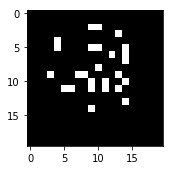

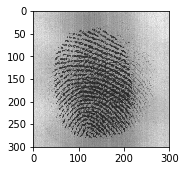

In [131]:
k = 35 #numero de imagen

#Imagen de la etiquetas
visualizar_imagen(y_train[(k-1)*d**2//n**2:k*d**2//n**2].reshape(d//n,d//n))

#imagen de la huella digital
os.chdir(path+"\DB_3")
fingerprint = imread("img_"+str(k)+".jpg")
visualizar_imagen(fingerprint)

El flujo de trabajo será el siguiente: primero, alimentaremos a la red neuronal con los datos de entrenamiento, ``train_images`` y ``train_labels``. La red aprenderá a asociar imágenes y etiquetas. Finalmente, le pediremos a la red que produzca predicciones para ``test_images``, y verificaremos si estas predicciones coinciden con las etiquetas de ``test_labels`` a traves de la metrica ``acuracy`` (exactitud).

El componente básico de las redes neuronales es la capa, un módulo de procesamiento de datos que se puede considerar como un filtro para los datos. Algunos datos entran, y salen en una forma más útil. Específicamente, las capas extraen representaciones de los datos que ingresan en ellas, con suerte, representaciones que son más significativas para el problema en cuestión. La mayor parte del aprendizaje profundo consiste en encadenar capas simples que implementarán una forma de destilación de datos progresiva. Un modelo de aprendizaje profundo es como un tamiz para el procesamiento de datos, hecho de una sucesión de filtros de datos cada vez más refinados: las capas. 

Aquí, nuestra red consiste en una secuencia de dos capas densas, que son capas de redes neuronales densamente conectadas (también llamadas totalmente conectadas). La segunda (y última) capa es una capa de softmax de 2 salidas, lo que significa que devolverá una matriz de 2 puntuaciones de probabilidad (que se suman 1). Cada puntaje será la probabilidad de que la imagen del dígito actual pertenezca a una de nuestras clases $y_i \in \{ 0, 1 \}$ (minuta o no minuta).

In [138]:
network = models.Sequential()
network.add(layers.Dense(8000, activation='relu', input_shape=(n**2,)))
network.add(layers.Dense(2, activation='softmax'))

Para preparar la red para la capacitación, debemos elegir tres cosas más, como parte del paso de compilación:

* **loss:** Una función de pérdida en la cual la red podrá medir su rendimiento en los datos de entrenamiento y, por lo tanto, cómo podrá dirigirse en la dirección correcta.

* **optimizer:** Un optimizador cuyo mecanismo tomará la red para actualizar la estructura, basándose en los datos que ve y su función de pérdida.

* **metrics:** Métricas para monitorear durante el entrenamiento y las pruebas. Aquí, solo nos importará la precisión (la fracción de las imágenes que se clasificaron correctamente).

In [139]:
network.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

Antes de entrenar, preprocesaremos los datos cambiándolos a la forma que la red espera y escalando de modo que todos los valores estén en el intervalo [0,1] dividiendo entre el valor del maximo elemento (255). También necesitamos codificar categóricamente las etiquetas con la funcion de Keras ``to_categorical()``. La base de datos es separada en dos partes (8,000 datos), los datos de entrenamiento y los datos de validación (24,000 datos).

In [140]:
#Imagenes de entrenamiento
train_labels = to_categorical(y_train[:8000])
train_images = X_train[:8000,:]/255

#Imagenes de validacion
test_labels = to_categorical(y_train[200:24200])
test_images = X_train[8000:,:]/255

Ahora estamos listos para entrenar a la red, lo que en Keras se realiza mediante una llamada al método ``fit`` de la red. Aquí, la red utiliza los 8,000 datos en paquetes de 100 (``batch_size``) y se actualiza en 5 epocas. 

In [165]:
model = network.fit(train_images, train_labels, epochs=5, batch_size=1000, validation_data=(test_images, test_labels))

Train on 8000 samples, validate on 24000 samples
Epoch 1/5
8000/8000 [==============================] - 2s 246us/step - loss: 0.2890 - acc: 0.9148 - val_loss: 0.2882 - val_acc: 0.9165
Epoch 2/5
8000/8000 [==============================] - 2s 243us/step - loss: 0.2882 - acc: 0.9148 - val_loss: 0.2875 - val_acc: 0.9165
Epoch 3/5
8000/8000 [==============================] - 2s 243us/step - loss: 0.2871 - acc: 0.9148 - val_loss: 0.2880 - val_acc: 0.9165
Epoch 4/5
8000/8000 [==============================] - 2s 247us/step - loss: 0.2870 - acc: 0.9148 - val_loss: 0.2883 - val_acc: 0.9165
Epoch 5/5
8000/8000 [==============================] - 2s 239us/step - loss: 0.2864 - acc: 0.9148 - val_loss: 0.2888 - val_acc: 0.9165


In [121]:
model.params

{'batch_size': 1000,
 'epochs': 5,
 'steps': None,
 'samples': 8000,
 'verbose': 1,
 'do_validation': True,
 'metrics': ['loss', 'acc', 'val_loss', 'val_acc']}

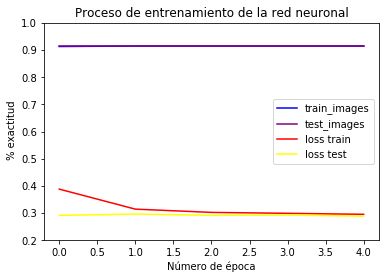

In [163]:
plt.ylim((0.2,1))
plt.xlabel("Número de época")
plt.ylabel(" % exactitud")
plt.title("Proceso de entrenamiento de la red neuronal")
plt.plot(model.history['acc'], color= 'blue')
plt.plot(model.history['val_acc'], color= 'purple')
plt.plot(model.history['loss'], color='red')
plt.plot(model.history['val_loss'], color='yellow')
plt.legend(["train_images","test_images", "loss train", "loss test"])
plt.show()

#### Conclusiones
La precisión en la predicción de las clases del conjunto de datos de validación resultó ser del 91.65%, que es más alta que la precisión del conjunto de entrenamiento con un 91.48%. Esta brecha entre la precisión del entrenamiento y la precisión de la prueba es un ejemplo un equilibrio entre ambas precisiones, por lo que podemos decir que nuetro modelo carece de overfitting. 
Notamos algo entraño al entrenar la red neuronal, y eso era que al calcular la precisión, tanto en los datos de entrenamiento como en los datos de validación, la precisión apenas si cambiaba y desde la primera epoca, era alta (vea el entrenamiento de la red). Al principio, creiamos que se debia a una mala implementación o simplemente un error al asignar las etiqutas; pero ninguna de las anteriores se detectó al hacer una inspección de los datos. Por esto, creemos que nuetros resultados son satisfactorios (más de lo esperado). Para explicar este extraño fenomeno, habría que investigar de una manera más detallada, como funcionan estas redes neuronales implementadas en Keras.